In [41]:
import sys
sys.path.append('..')

from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import tensorflow.keras as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse
from tensorflow.keras.layers import Dense,LeakyReLU,BatchNormalization,Input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import evaluation

In [11]:
try:
    train_data=pd.read_csv('../../data/numerai_dataset_252/numerai_training_data.csv').set_index('id')
    test_data=pd.read_csv('../../data/numerai_dataset_252/numerai_tournament_data.csv').set_index('id')
except Exception as e:
    print(e)
    #num_api = numerapi.NumerAPI(public_key, secret_key,verbosity="info")
    #num_api.download_current_dataset(dest_path='../data/')

In [12]:
feature_names = [f for f in train_data if 'feature' in f]

In [33]:
x_train=train_data[feature_names]
x_test=test_data[feature_names]

In [14]:
OPT = Adam()
LOSS = mse

In [53]:
class AutoEncoder():
    def __init__(self, f_dims, new_dims):
        self.f_dims=f_dims
        self.new_dims=f_dims[1] if new_dims is None else new_dims

        
    def dense_layer(self, x, size=1):
        x = Dense(self.f_dims[1]*size)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        return x

    
    def encoder(self,x):
        e1 = self.dense_layer(x, 2)
        e2 = self.dense_layer(x)
        return e2


    def decoder(self,x):
        d1 = self.dense_layer(x)
        d2 = self.dense_layer(x, 2)
        return d2
        
        
    def build(self):
    
        x_in = Input((self.f_dims[1],))
        
        x = self.encoder(x_in)
        x = Dense(self.new_dims)(x)
        x = self.decoder(x)
        x_out = Dense(self.f_dims[1], activation='linear')(x)
        model = Model(x_in,x_out)
    
        return model

In [54]:
ae=AutoEncoder(x_train.shape,310)
model=ae.build()
model.compile(optimizer=OPT, loss=LOSS)
history=model.fit(x_train, x_train, epochs=200, batch_size=16, verbose=2, validation_data=(x_test,x_test))

KeyboardInterrupt: 

In [55]:
ae=AutoEncoder(x_train.shape,64)
model=ae.build()
model.compile(optimizer=OPT, loss=LOSS)
history_2=model.fit(x_train, x_train, epochs=200, batch_size=16, verbose=2, validation_data=(x_test,x_test))

Epoch 1/200
31363/31363 - 140s - loss: 0.0327 - val_loss: 0.0229
Epoch 2/200
31363/31363 - 131s - loss: 0.0290 - val_loss: 0.0226
Epoch 3/200
31363/31363 - 120s - loss: 0.0286 - val_loss: 0.0222
Epoch 4/200
31363/31363 - 113s - loss: 0.0283 - val_loss: 0.0220
Epoch 5/200
31363/31363 - 115s - loss: 0.0281 - val_loss: 0.0221
Epoch 6/200
31363/31363 - 115s - loss: 0.0279 - val_loss: 0.0218
Epoch 7/200
31363/31363 - 112s - loss: 0.0278 - val_loss: 0.0218
Epoch 8/200


KeyboardInterrupt: 

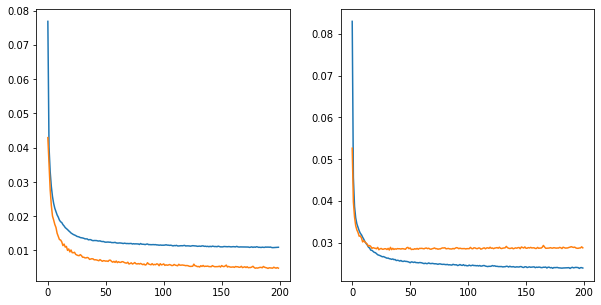

In [20]:
f,axes=plt.subplots(1,2,figsize=(10,5))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])

axes[1].plot(history_2.history['loss'])
axes[1].plot(history_2.history['val_loss'])

In [35]:
x_train_ae = model.predict(x_train)
x_test_ae = model.predict(x_test)

In [28]:
params={'num_leaves': [30, 40, 50], 
        'max_depth': [4, 5, 6], 
        'learning_rate': [0.05, 0.01, 0.005],
        'bagging_freq':[7], 
        'bagging_fraction': [0.6, 0.7, 0.8], 
        'feature_fraction': [0.85, 0.75, 0.65]}

In [49]:
lgb=LGBMRegressor()
lgb_randomsearch=RandomizedSearchCV(estimator=lgb,cv=2, param_distributions=params, n_iter=100)
lgb_model=lgb_randomsearch.fit(x_train_ae[:1000],train_data['target'][:1000])
lgb_model_best=lgb_model.best_estimator_
lgb_model_best=lgb_model_best.fit(x_train_ae[:1000],train_data['target'][:1000])


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=7, subsample_f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=7, subsample_f

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=7, subsample_f

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=7, subsample_f

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_f

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=7, subsample_f

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=7, subsample_f

In [50]:
lgb_model_best=lgb_model.best_estimator_
print("Generating all predictions...")
train_data['prediction'] = lgb_model_best.predict(x_train_ae)
test_data['prediction'] = lgb_model_best.predict(x_test_ae)

Generating all predictions...


In [51]:
train_corrs = (evaluation.per_era_score(train_data))
print('train correlations mean: {}, std: {}'.format(train_corrs.mean(), train_corrs.std(ddof=0)))
#print('avg per-era payout: {}'.format(evaluation.payout(train_corrs).mean()))

train correlations mean: 0.008048024459973685, std: 0.04082698502306705


In [52]:
valid_data = test_data[test_data.data_type == 'validation']
valid_corrs = evaluation.per_era_score(valid_data)
#valid_sharpe = evaluation.sharpe(valid_data) 
print('valid correlations mean: {}, std: {}'.format(valid_corrs.mean(), valid_corrs.std(ddof=0)))
#print('avg per-era payout {}'.format(evaluation.payout(valid_corrs.mean())))
#print('valid sharpe: {}'.format(valid_sharpe))

valid correlations mean: 0.0016191018676691125, std: 0.020244259581521703


In [ ]:
live_data = test_data[test_data.data_type == "test"]
live_corrs = evaluation.per_era_score(live_data)
#test_sharpe = evaluation.sharpe(live_data) 
print('live correlations - mean: {}, std: {}'.format(live_corrs.mean(), live_corrs.std(ddof=0)))
#print('avg per-era payout is {}'.format(evaluation.payout(live_corrs).mean()))
#print('live Sharpe: {}'.format(test_sharpe))

In [56]:
x_train_ae.shape

(501808, 310)